In [19]:
import pickle
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [20]:
def plot_point_cloud(point_cloud, ax, title="Point Cloud"):
    ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2])
    ax.set_title(title)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

In [52]:
# Load the combined flattened images, labels, and original point clouds
with open('Data/m_combined_flattened_data_with_indices.pkl', 'rb') as f_img:
#with open('Data/m_flattened_images_with_indices.pkl', 'rb') as f_img:
    combined_flattened_data = pickle.load(f_img)

# Extracting indices, combined vectors, and labels
indices, combined_vectors, labels = zip(*combined_flattened_data)

# Convert to numpy arrays
combined_vectors = np.array(combined_vectors)
labels = np.array(labels)

# Load the original point clouds for visualization
with open('m_shapes_data.pkl', 'rb') as file:
    original_shape_data = pickle.load(file)

# Extracting indices, combined vectors, and labels
indices2, combined_vectors2, labels2 = zip(*original_shape_data)

In [53]:
# Train-test split with stratification
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    combined_vectors, labels, indices, test_size=0.3, random_state=42, stratify=labels
)

# Initialize and train the SVM model
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, y_train)

SVC()

Accuracy: 0.83
Looking for original index: 59
Test Sample 1 - Predicted Class: line_segment, Actual Class: line_segment
Looking for original index: 43
Test Sample 2 - Predicted Class: line_segment, Actual Class: line_segment
Looking for original index: 131
Test Sample 3 - Predicted Class: perturbed_3_disc, Actual Class: perturbed_3_disc
Looking for original index: 76
Test Sample 4 - Predicted Class: torus, Actual Class: torus
Looking for original index: 14
Test Sample 5 - Predicted Class: sphere, Actual Class: sphere


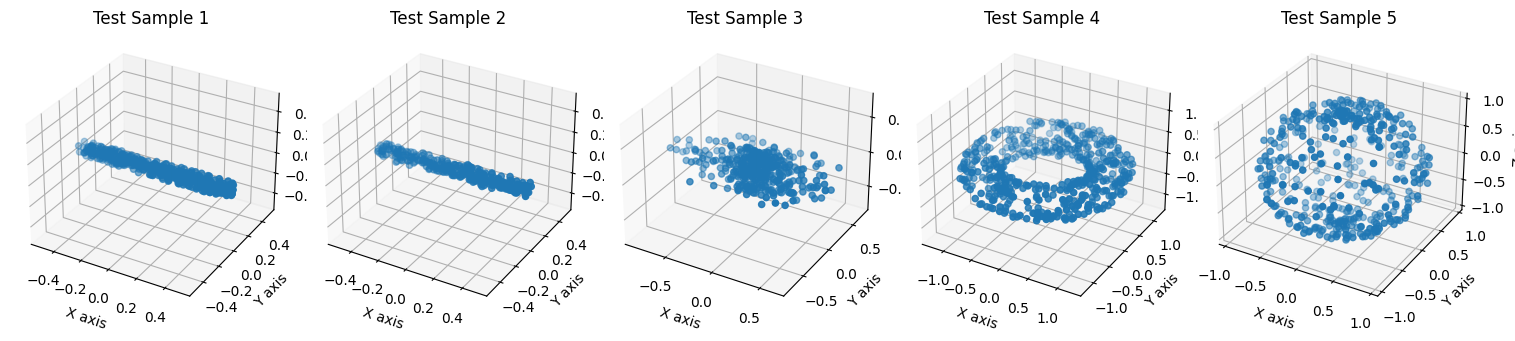

In [59]:
# Reverse the mapping from shape names to label numbers
label_names = {0: "sphere", 1: "circle", 2: "line_segment", 3: "torus", 4: "flat_disc", 5: "ellipsoid", 6: "perturbed_3_disc"}

# Predict on the test set
y_pred = svm_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Visualize a few test samples, their predictions, and actual labels
num_samples_to_visualize = 5
fig = plt.figure(figsize=(15, 10))

for i in range(num_samples_to_visualize):
    # Get the original point cloud index from the test set
    original_index = idx_test[i]
    print(f"Looking for original index: {original_index}")

    # Find the test point cloud using the index
    test_point_cloud = next((pc for idx, pc, _ in original_shape_data if idx == original_index), None)

    if test_point_cloud is not None:
        # Plot the point cloud
        ax = fig.add_subplot(2, num_samples_to_visualize, i + 1, projection='3d')
        plot_point_cloud(test_point_cloud, ax, title=f"Test Sample {i+1}")

        # Set the same scale for all axes
        max_range = np.array([test_point_cloud[:,0].max()-test_point_cloud[:,0].min(), 
                              test_point_cloud[:,1].max()-test_point_cloud[:,1].min(), 
                              test_point_cloud[:,2].max()-test_point_cloud[:,2].min()]).max() / 2.0
        mid_x = (test_point_cloud[:,0].max()+test_point_cloud[:,0].min()) * 0.5
        mid_y = (test_point_cloud[:,1].max()+test_point_cloud[:,1].min()) * 0.5
        mid_z = (test_point_cloud[:,2].max()+test_point_cloud[:,2].min()) * 0.5
        ax.set_xlim(mid_x - max_range, mid_x + max_range)
        ax.set_ylim(mid_y - max_range, mid_y + max_range)
        ax.set_zlim(mid_z - max_range, mid_z + max_range)

        # Print the prediction and actual label
        predicted_label = y_pred[i]
        actual_label = y_test[i]
        predicted_shape = label_names.get(predicted_label, "Unknown")
        actual_shape = label_names.get(actual_label, "Unknown")
        print(f"Test Sample {i+1} - Predicted Class: {predicted_shape}, Actual Class: {actual_shape}")
    else:
        print(f"Test Sample {i+1} - Original point cloud not found for index {original_index}")

plt.tight_layout()
plt.show()


In [45]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a mapping from label numbers to shape names (update based on your labels)
shape_names = {0: 'sphere', 1: 'circle', 2: 'line_segment', 3: 'torus', 4: 'flat_disc', 5: 'ellipsoid', 6: 'perturbed_3_disc'}

# Calculate and display class-wise accuracy
for class_index, class_name in shape_names.items():
    correct = conf_matrix[class_index, class_index]
    incorrect = sum(conf_matrix[class_index, :]) - correct
    print(f"Class '{class_name}': Correctly classified: {correct}, Incorrectly classified: {incorrect}")



Class 'sphere': Correctly classified: 6, Incorrectly classified: 0
Class 'circle': Correctly classified: 6, Incorrectly classified: 0
Class 'line_segment': Correctly classified: 6, Incorrectly classified: 0
Class 'torus': Correctly classified: 6, Incorrectly classified: 0
Class 'flat_disc': Correctly classified: 5, Incorrectly classified: 1
Class 'ellipsoid': Correctly classified: 5, Incorrectly classified: 1
Class 'perturbed_3_disc': Correctly classified: 1, Incorrectly classified: 5


In [46]:
# Predict on the training set
y_train_pred = svm_model.predict(X_train)

# Calculate the confusion matrix for training data
conf_matrix_train = confusion_matrix(y_train, y_train_pred)

# Create a mapping from label numbers to shape names (update based on your labels)
shape_names = {0: 'sphere', 1: 'circle', 2: 'line_segment', 3: 'torus', 4: 'flat_disc', 5: 'ellipsoid', 6: 'perturbed_3_disc'}

# Calculate and display class-wise accuracy for training data
for class_index, class_name in shape_names.items():
    correct_train = conf_matrix_train[class_index, class_index]
    incorrect_train = sum(conf_matrix_train[class_index, :]) - correct_train
    print(f"Training Data - Class '{class_name}': Correctly classified: {correct_train}, Incorrectly classified: {incorrect_train}")


Training Data - Class 'sphere': Correctly classified: 7, Incorrectly classified: 7
Training Data - Class 'circle': Correctly classified: 14, Incorrectly classified: 0
Training Data - Class 'line_segment': Correctly classified: 14, Incorrectly classified: 0
Training Data - Class 'torus': Correctly classified: 12, Incorrectly classified: 2
Training Data - Class 'flat_disc': Correctly classified: 14, Incorrectly classified: 0
Training Data - Class 'ellipsoid': Correctly classified: 11, Incorrectly classified: 3
Training Data - Class 'perturbed_3_disc': Correctly classified: 5, Incorrectly classified: 9


In [47]:
# Calculate accuracy
accuracy_train = accuracy_score(y_train, y_train_pred)
print(f"Accuracy: {accuracy_train:.2f}")

Accuracy: 0.79
